# Hands-on Day 2

## You'll learn

### ML methods
- Gradient Boosting Trees with pyspark.ml

### ML techniques
- hyperparameter optimisation
- ROC curves

In [1]:
#initial imports
%reload_ext custom_magics
%load_ext autoreload
%autoreload 2

# initial setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Check out these custom functions
from custom_functions import *

In [45]:
num_workers=5
spark=%sc $num_workers

from pyspark.sql import SparkSession
spark_session = SparkSession(spark)

#check if spark is there
spark

<SparkContext master=k8s://https://192.168.2.39:6443 appName=jupyter-annalisagilioli>

# Data preprocessing

In [3]:
# read input file
inputFile = 'file:///data-corso/Higgs100k.csv'
#inputFile = 'file:///data-corso/Higgs1M.csv'
#inputFile = 'file:///data-corso/Higgs10M.csv'

%time df = spark_session.read.format('csv').option('header', 'true').option('inferschema', 'true').load(inputFile)
total_events = df.count()
print('There are '+str(total_events)+' events')

CPU times: user 3.36 ms, sys: 3.43 ms, total: 6.78 ms
Wall time: 10.4 s
There are 99999 events


In [4]:
df.head()

Row(label=1.0, lepton_pT=0.869293212890625, lepton_eta=-0.6350818276405334, lepton_phi=0.22569026052951813, missing_energy_magnitude=0.327470064163208, missing_energy_phi=-0.6899932026863098, jet1_pt=0.7542022466659546, jet1_eta=-0.24857313930988312, jet1_phi=-1.0920639038085938, jet1_b-tag=0.0, jet2_pt=1.3749921321868896, jet2_eta=-0.6536741852760315, jet2_phi=0.9303491115570068, jet2_b-tag=1.1074360609054565, jet3_pt=1.138904333114624, jet3_eta=-1.5781983137130737, jet3_phi=-1.046985387802124, jet3_b-tag=0.0, jet4_pt=0.657929539680481, je4_eta=-0.010454569943249226, jet4_phi=-0.0457671694457531, jet4_b-tag=3.101961374282837, m_jj=1.353760004043579, m_jjj=0.9795631170272827, m_lv=0.978076159954071, m_jlv=0.9200048446655273, m_bb=0.7216574549674988, m_wbb=0.9887509346008301, m_wwbb=0.8766783475875854)

##  Exercise 1

- split the dataframe *df* into two dataframes, called *train* and *test* containing respectively 80% and 20% of the events (randomly distributed between the two samples) 

In [5]:
#split the dataset for training and test
weights = [0.8, 0.2]
train, test = df.randomSplit(weights, seed=None)
 
print("Splitted Dataframe")
print('Events for training {}'.format(train.count()))
print('Events for validation {}'.format(test.count()))

Splitted Dataframe
Events for training 80053
Events for validation 19946


#### Create the input feature vector - remember, this was part of yesterday hands-on (bonus)

- Libraries for ML tipically take as inputs data in a very specific format. Documentation on how to do data preprocessing in Spark: https://spark.apache.org/docs/latest/ml-features.html
- Try to add to the dataframe *train* a new column, called 'features' which is a vector column with all the variables above except for 'label'
   - features = [lepton_pT, lepton_eta, lepton_phi, ...]
   - Hint: look at the VectorAssembler transformer
- do the same for dataframe *test*

In [6]:
feature = df.columns
first_element = feature.pop(0)
# feature

In [7]:
assembler = VectorAssembler(
    inputCols=feature,
    outputCol="features")

In [8]:
train = assembler.transform(train)
#train.show(truncate=True)

display(train)
train.select('features').take(1)

DataFrame[label: double, lepton_pT: double, lepton_eta: double, lepton_phi: double, missing_energy_magnitude: double, missing_energy_phi: double, jet1_pt: double, jet1_eta: double, jet1_phi: double, jet1_b-tag: double, jet2_pt: double, jet2_eta: double, jet2_phi: double, jet2_b-tag: double, jet3_pt: double, jet3_eta: double, jet3_phi: double, jet3_b-tag: double, jet4_pt: double, je4_eta: double, jet4_phi: double, jet4_b-tag: double, m_jj: double, m_jjj: double, m_lv: double, m_jlv: double, m_bb: double, m_wbb: double, m_wwbb: double, features: vector]

[Row(features=DenseVector([0.2758, -2.1077, 1.6889, 1.9085, 0.5887, 1.2632, 1.3635, -1.1625, 0.0, 0.5701, 0.6752, -0.7686, 0.0, 1.007, 1.5239, 1.5276, 0.0, 2.206, -0.4685, 0.2762, 3.102, 0.8865, 0.7056, 0.9947, 0.7695, 0.5959, 1.1519, 1.4402]))]

In [9]:
test = assembler.transform(test)
#train.show(truncate=True)

display(test)
test.select('features').take(1)

DataFrame[label: double, lepton_pT: double, lepton_eta: double, lepton_phi: double, missing_energy_magnitude: double, missing_energy_phi: double, jet1_pt: double, jet1_eta: double, jet1_phi: double, jet1_b-tag: double, jet2_pt: double, jet2_eta: double, jet2_phi: double, jet2_b-tag: double, jet3_pt: double, jet3_eta: double, jet3_phi: double, jet3_b-tag: double, jet4_pt: double, je4_eta: double, jet4_phi: double, jet4_b-tag: double, m_jj: double, m_jjj: double, m_lv: double, m_jlv: double, m_bb: double, m_wbb: double, m_wwbb: double, features: vector]

[Row(features=DenseVector([0.2778, 1.4531, -1.5111, 2.0992, -0.6316, 1.225, -0.1307, 1.1206, 2.1731, 0.9434, -0.9111, -1.2042, 0.0, 0.8651, -0.7635, 0.1907, 0.0, 0.6158, 0.1036, 1.6635, 3.102, 1.3197, 0.8587, 0.9874, 1.5045, 0.4468, 0.9412, 0.9698]))]

# ML models: GBT

In [10]:
# ML model: GBT (Gradient Boosting Trees)
# Documentation at https://spark.apache.org/docs/2.2.0/ml-classification-regression.html
from pyspark.ml.classification import GBTClassifier

# fast, about 1m to train
gbt = GBTClassifier(labelCol='label', featuresCol='features', maxIter=50, maxDepth=10) 

In [11]:
%%time
gbt_model = gbt.fit(train)

CPU times: user 69.1 ms, sys: 34.6 ms, total: 104 ms
Wall time: 5min 44s


In [12]:
# compute AUC on the test set
result = gbt_model.transform(test)

from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol='label', metricName="areaUnderROC")
print("Test set AUC = " + str(evaluator.evaluate(result)))

Test set AUC = 0.7828826054682518


In [13]:
#print metrics
printMetrics(evaluator, result)

AUC: 0.783
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0| 7793|
|  0.0|       1.0| 2972|
|  1.0|       0.0| 2783|
|  0.0|       0.0| 6398|
+-----+----------+-----+

n precision: 0.724
n recall: 0.737
n accuracy: 0.711
n F1 score: 0.730


In [14]:
gbt_model.extractParamMap()

{Param(parent='GBTClassifier_ad1afcc0d83a', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval.'): False,
 Param(parent='GBTClassifier_ad1afcc0d83a', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext.'): 10,
 Param(parent='GBTClassifier_ad1afcc0d83a', name='featureSubsetStrategy', doc="The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for r

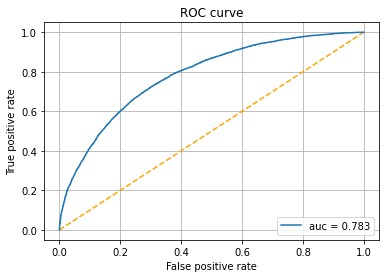

In [15]:
#make ROC curve
drawROC(result)

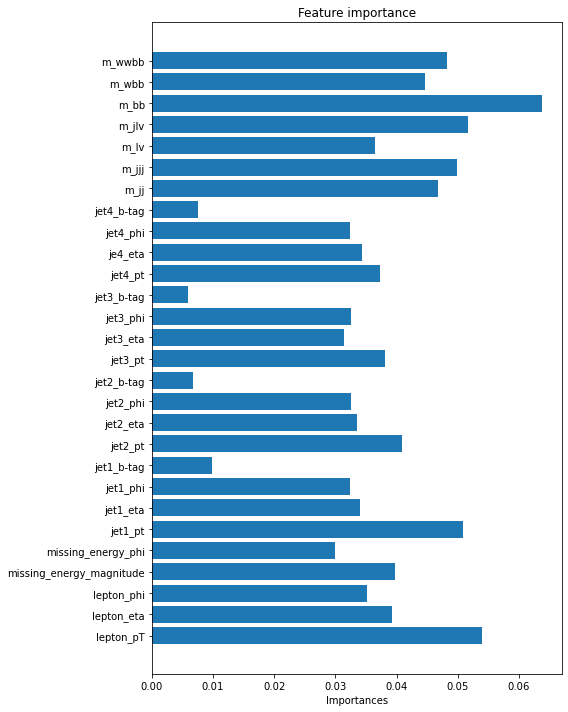

In [16]:
#plot features vs importance
drawFeatures(feature, gbt_model)

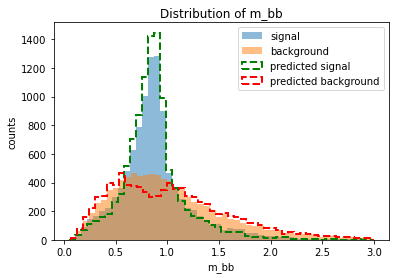

In [17]:
#plot signal vs background with prediction
plotSignalvsBgWithPrediction(test, result, 'm_bb')

## Exercise 2

- try to change the hyperparameters of the GBT model (maxIter=50, maxDepth=10), and check what changes in terms of performances, feature importance, signal versus background separation. Be careful of training time if you increase them too much!

# Hyperparameter scan

- documentation: https://spark.apache.org/docs/latest/ml-tuning.html

In [18]:
#reduce number of events for training if needed
subSample = train.sample(fraction=1.0/10, withReplacement=False).cache()
print('We will use ' +str(subSample.count()) + ' events for the grid search')

We will use 7959 events for the grid search


In [ ]:
#Do hyperparameter tuning 
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, TrainValidationSplit
from pyspark.ml.evaluation import BinaryClassificationEvaluator

gbt = GBTClassifier(labelCol='label', featuresCol='features', maxIter=10, maxDepth=3)

evaluator=BinaryClassificationEvaluator(metricName='areaUnderROC')

#choose hyperparameter space
paramGrid = ParamGridBuilder()\
  .addGrid(gbt.maxDepth, [1,5])\
  .addGrid(gbt.maxIter, [10,20])\
  .build()



In [35]:
# Train Validation Split (takes 1-2 minutes)
tvs = TrainValidationSplit(estimator=gbt,
                           estimatorParamMaps=paramGrid,
                           evaluator=evaluator,
                           trainRatio=0.8)# 80% of the data will be used for training, 20% for validation

**TIP:** after starting the following cell, close the Spark monitoring window or it will slow down your notebook display considerably.

In [21]:
#take care, might take long time, 
%time bestModel = tvs.fit(subSample)

CPU times: user 281 ms, sys: 161 ms, total: 441 ms
Wall time: 6min 57s


In [22]:
#It is possile to see the score obtained (in this case the AUC) for each set of parameters
#zip(bestModel.avgMetrics, paramGrid)

print('maxDepth = '+str(bestModel.bestModel._java_obj.getMaxDepth()))
print('maxIter = '+str(bestModel.bestModel._java_obj.getMaxIter()))

maxDepth = 5
maxIter = 30


In [23]:
# compute accuracy on the test set
result = bestModel.transform(test)

evaluator = BinaryClassificationEvaluator(labelCol='label', metricName="areaUnderROC")
print("Test set AUC = " + str(evaluator.evaluate(result)))

Test set AUC = 0.7611390623662927


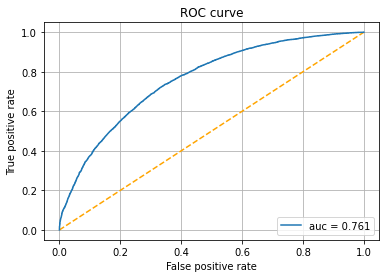

In [24]:
#make ROC curve with best model
drawROC(result)

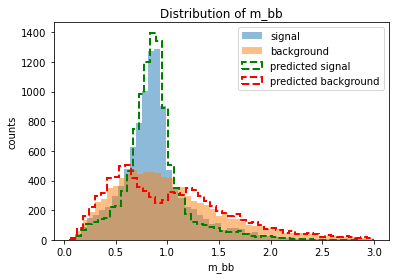

In [ ]:
#plot signal vs background with prediction
plotSignalvsBgWithPrediction(test, result, 'm_bb')

## Exercise 3

- try implementing the cross validation method, and describe what changes (results, training time, performances, ...): do you get the same hyper-parameters?

In [ ]:
from pyspark.ml.tuning import CrossValidator
cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

In [ ]:
#cvModel = cv.fit(train)
#cvModel.getNumFolds()
#cvModel.avgMetrics[0]

In [28]:
#take care, might take long time, 
%time bestcvModel = cv.fit(subSample)

CPU times: user 1.06 s, sys: 487 ms, total: 1.54 s
Wall time: 4min 57s


In [29]:
#It is possile to see the score obtained (in this case the AUC) for each set of parameters
#zip(bestModel.avgMetrics, paramGrid)

print('maxDepth = '+str(bestcvModel.bestModel._java_obj.getMaxDepth()))
print('maxIter = '+str(bestcvModel.bestModel._java_obj.getMaxIter()))

maxDepth = 5
maxIter = 20


In [30]:
# compute accuracy on the test set
result = bestcvModel.transform(test)

evaluator = BinaryClassificationEvaluator(labelCol='label', metricName="areaUnderROC")
print("Test set AUC = " + str(evaluator.evaluate(result)))

Test set AUC = 0.7568393359968485


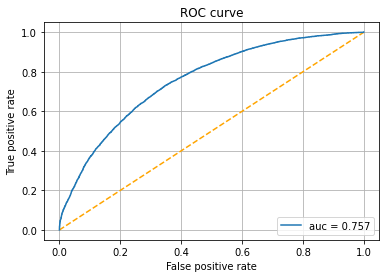

In [31]:
#make ROC curve with best model
drawROC(result)

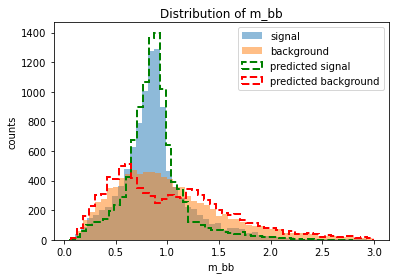

In [32]:
#plot signal vs background with prediction
plotSignalvsBgWithPrediction(test, result, 'm_bb')

In [47]:
#when you're done, stop spark, this will release the resources you're using
spark.stop()